In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
#
#   LEARN FCN00
#

from __future__ import print_function
import argparse
import os

import numpy as np
import pickle
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, AveragePooling2D
from keras.layers import merge
from keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import list_pictures, array_to_img

from image_ext import list_pictures_in_multidir, load_imgs_asarray, img_dice_coeff
from fname_func import load_fnames, make_fnames

# MAXPOOLING
from create_fcn import create_fcn00
# AVERAGE POOLING
#from create_fcn_avpool import create_fcn01,create_fcn00

np.random.seed(2016)

/home/nakazawa_atsushi/anaconda3/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/nakazawa_atsushi/anaconda3/envs/py3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return (2.*intersection + 1) / (K.sum(y_true) + K.sum(y_pred) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [3]:
#
#  MAIN STARTS FROM HERE
#
if __name__ == '__main__':
    
    target_size = (224, 224)
    dpath_this = './'
    # dname_checkpoints = 'checkpoints_fcn00_avpool.augumented'
    dname_checkpoints = 'checkpoints_fcn00.Gi4E'
    dname_checkpoints_fcn00 = 'checkpoints_fcn00.augumented_2'    
    dname_outputs = 'outputs'
    fname_architecture = 'architecture.json'
    fname_weights = "model_weights_{epoch:02d}.h5"
    fname_stats = 'stats01.npz'
    dim_ordering = 'channels_first'
    fname_history = 'history.pkl'

    # モデルを作成
    print('creating model fcn00...')
    model_fcn00 = create_fcn00(target_size)
    
    # 学習済みの重みをロード(UBIRIS + Augumented2)
    print('loading weight..')
    epoch = 200
    fname_weights = 'model_weights_%02d.h5'%(epoch)
    fpath_weights = os.path.join(dname_checkpoints_fcn00, fname_weights)
    model_fcn00.load_weights(fpath_weights)
    print('==> done')
    
    if os.path.exists(dname_checkpoints) == 0:
        os.mkdir(dname_checkpoints)

creating model fcn00...
loading weight..
==> done


In [4]:
    #
    #   LEARNING MODE
    #
    # Read Learning Data
    fnames = load_fnames('data.gi4e/list_train.txt')
    [fpaths_xs_train,fpaths_ys_train] = make_fnames(fnames,'data.gi4e/left/img','data.gi4e/left/mask','')
    [fpaths_xs_train_R,fpaths_ys_train_R] = make_fnames(fnames,'data.gi4e/right/img','data.gi4e/right/mask','')
    fpaths_xs_train.extend(fpaths_xs_train_R)
    fpaths_ys_train.extend(fpaths_ys_train_R)
    
    print('reading training data')
    X_train = load_imgs_asarray(fpaths_xs_train, grayscale=False, target_size=target_size,
                                dim_ordering=dim_ordering)
    print('reading traking gt data')
    Y_train = load_imgs_asarray(fpaths_ys_train, grayscale=True, target_size=target_size,
                                dim_ordering=dim_ordering) 

    # Read Validation Data
    #    fnames = load_fnames('data/list_valid_01.txt')
    #    [fpaths_xs_valid,fpaths_ys_valid] = make_fnames(fnames,'data/img','data/mask','OperatorA_')
    fnames = load_fnames('data.gi4e/list_valid.txt')
    [fpaths_xs_valid,fpaths_ys_valid] = make_fnames(fnames,'data.gi4e/left/img','data.gi4e/left/mask','')
    [fpaths_xs_valid_R,fpaths_ys_valid_R] = make_fnames(fnames,'data.gi4e/right/img','data.gi4e/right/mask','')
    fpaths_xs_valid.extend(fpaths_xs_valid_R)
    fpaths_ys_valid.extend(fpaths_ys_valid_R)
    
    print('reading validation data')
    X_valid = load_imgs_asarray(fpaths_xs_valid, grayscale=False, target_size=target_size,
                                dim_ordering=dim_ordering)
    Y_valid = load_imgs_asarray(fpaths_ys_valid, grayscale=True, target_size=target_size,
                                dim_ordering=dim_ordering)     

    print('==> ' + str(len(X_train)) + ' training images loaded')
    print('==> ' + str(len(Y_train)) + ' training masks loaded')
    print('==> ' + str(len(X_valid)) + ' validation images loaded')
    print('==> ' + str(len(Y_valid)) + ' validation masks loaded')

    # 前処理
    print('computing mean and standard deviation...')
    mean = np.mean(X_train, axis=(0, 2, 3))
    std = np.std(X_train, axis=(0, 2, 3))
    print('==> mean: ' + str(mean))
    print('==> std : ' + str(std))

reading training data
reading traking gt data
reading validation data
==> 2232 training images loaded
==> 2232 training masks loaded
==> 240 validation images loaded
==> 240 validation masks loaded
computing mean and standard deviation...
==> mean: [92.11654 92.11654 92.11654]
==> std : [44.57933 44.57933 44.57933]


In [5]:
    print('saving mean and standard deviation to ' + fname_stats + '...')
    stats = {'mean': mean, 'std': std}
    np.savez(dname_checkpoints + '/' + fname_stats, **stats)
    print('==> done')

    print('globally normalizing data...')
    for i in range(3):
        X_train[:, i] = (X_train[:, i] - mean[i]) / std[i]
        X_valid[:, i] = (X_valid[:, i] - mean[i]) / std[i]
    Y_train /= 255
    Y_valid /= 255
    print('==> done')

saving mean and standard deviation to stats01.npz...
==> done
globally normalizing data...
==> done


In [6]:
    # 損失関数，最適化手法を定義
    adam = Adam(lr=1e-5)
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.95, nesterov=True)
    #rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model_fcn00.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef])

    # 構造・重みを保存するディレクトリーの有無を確認
    dpath_checkpoints = os.path.join(dpath_this, dname_checkpoints)
    if not os.path.isdir(dpath_checkpoints):
        os.mkdir(dpath_checkpoints)

    # 重みを保存するためのオブジェクトを用意
    fname_weights = "model_weights_{epoch:02d}.h5"
    fpath_weights = os.path.join(dpath_checkpoints, fname_weights)
    checkpointer = ModelCheckpoint(filepath=fpath_weights, save_best_only=False)      

In [7]:
    # トレーニングを開始
    print('start training...')
    history = model_fcn00.fit(X_train[:,:,:,:], Y_train[:,:,:,:], batch_size=64, epochs=200, verbose=1,
                  shuffle=True, validation_data=(X_valid, Y_valid), callbacks=[checkpointer])

start training...
Train on 2232 samples, validate on 240 samples
Epoch 1/200
2232/2232 [==============================] - 124s 55ms/step - loss: -0.7761 - dice_coef: 0.7761 - val_loss: -0.8441 - val_dice_coef: 0.8441
Epoch 2/200
2232/2232 [==============================] - 87s 39ms/step - loss: -0.8287 - dice_coef: 0.8287 - val_loss: -0.8529 - val_dice_coef: 0.8529
Epoch 3/200
2232/2232 [==============================] - 87s 39ms/step - loss: -0.8412 - dice_coef: 0.8412 - val_loss: -0.8582 - val_dice_coef: 0.8582
Epoch 4/200
2232/2232 [==============================] - 87s 39ms/step - loss: -0.8489 - dice_coef: 0.8489 - val_loss: -0.8584 - val_dice_coef: 0.8584
Epoch 5/200
2232/2232 [==============================] - 87s 39ms/step - loss: -0.8550 - dice_coef: 0.8550 - val_loss: -0.8613 - val_dice_coef: 0.8613
Epoch 6/200
2232/2232 [==============================] - 87s 39ms/step - loss: -0.8615 - dice_coef: 0.8615 - val_loss: -0.8597 - val_dice_coef: 0.8597
Epoch 7/200
2232/2232 [=====

2232/2232 [==============================] - 88s 39ms/step - loss: -0.9793 - dice_coef: 0.9793 - val_loss: -0.8477 - val_dice_coef: 0.8477
Epoch 55/200
2232/2232 [==============================] - 87s 39ms/step - loss: -0.9797 - dice_coef: 0.9797 - val_loss: -0.8491 - val_dice_coef: 0.8491
Epoch 56/200
2232/2232 [==============================] - 88s 39ms/step - loss: -0.9801 - dice_coef: 0.9801 - val_loss: -0.8470 - val_dice_coef: 0.8470
Epoch 57/200
2232/2232 [==============================] - 87s 39ms/step - loss: -0.9788 - dice_coef: 0.9788 - val_loss: -0.8458 - val_dice_coef: 0.8458
Epoch 58/200
2232/2232 [==============================] - 88s 39ms/step - loss: -0.9808 - dice_coef: 0.9808 - val_loss: -0.8460 - val_dice_coef: 0.8460
Epoch 59/200
2232/2232 [==============================] - 87s 39ms/step - loss: -0.9815 - dice_coef: 0.9815 - val_loss: -0.8483 - val_dice_coef: 0.8483
Epoch 60/200
2232/2232 [==============================] - 88s 39ms/step - loss: -0.9810 - dice_coef: 

Epoch 108/200
2232/2232 [==============================] - 88s 39ms/step - loss: -0.9842 - dice_coef: 0.9842 - val_loss: -0.8496 - val_dice_coef: 0.8496
Epoch 109/200
2232/2232 [==============================] - 87s 39ms/step - loss: -0.9844 - dice_coef: 0.9844 - val_loss: -0.8496 - val_dice_coef: 0.8496
Epoch 110/200
2232/2232 [==============================] - 88s 39ms/step - loss: -0.9844 - dice_coef: 0.9844 - val_loss: -0.8500 - val_dice_coef: 0.8500
Epoch 111/200
2232/2232 [==============================] - 87s 39ms/step - loss: -0.9850 - dice_coef: 0.9850 - val_loss: -0.8516 - val_dice_coef: 0.8516
Epoch 112/200
2232/2232 [==============================] - 88s 39ms/step - loss: -0.9848 - dice_coef: 0.9848 - val_loss: -0.8501 - val_dice_coef: 0.8501
Epoch 113/200
2232/2232 [==============================] - 88s 39ms/step - loss: -0.9850 - dice_coef: 0.9850 - val_loss: -0.8496 - val_dice_coef: 0.8496
Epoch 114/200
2232/2232 [==============================] - 88s 39ms/step - loss: -

2232/2232 [==============================] - 88s 39ms/step - loss: -0.9860 - dice_coef: 0.9860 - val_loss: -0.8509 - val_dice_coef: 0.8509
Epoch 162/200
2232/2232 [==============================] - 88s 39ms/step - loss: -0.9858 - dice_coef: 0.9858 - val_loss: -0.8528 - val_dice_coef: 0.8528
Epoch 163/200
2232/2232 [==============================] - 88s 39ms/step - loss: -0.9860 - dice_coef: 0.9860 - val_loss: -0.8528 - val_dice_coef: 0.8528
Epoch 164/200
2232/2232 [==============================] - 88s 39ms/step - loss: -0.9861 - dice_coef: 0.9861 - val_loss: -0.8519 - val_dice_coef: 0.8519
Epoch 165/200
2232/2232 [==============================] - 88s 39ms/step - loss: -0.9863 - dice_coef: 0.9863 - val_loss: -0.8524 - val_dice_coef: 0.8524
Epoch 166/200
2232/2232 [==============================] - 88s 39ms/step - loss: -0.9856 - dice_coef: 0.9856 - val_loss: -0.8526 - val_dice_coef: 0.8526
Epoch 167/200
2232/2232 [==============================] - 87s 39ms/step - loss: -0.9859 - dice_

In [8]:
    # Save History
    f = open(dname_checkpoints + '/' + fname_history,'wb')
    pickle.dump(history.history,f)
    f.close

<function BufferedWriter.close>

checkpoints_fcn00.Gi4E/history.pkl


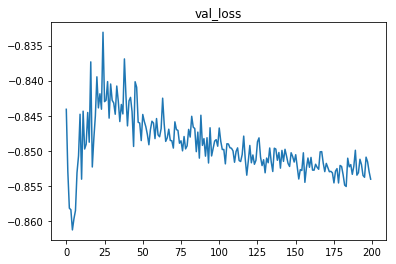

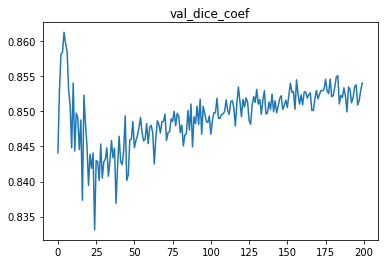

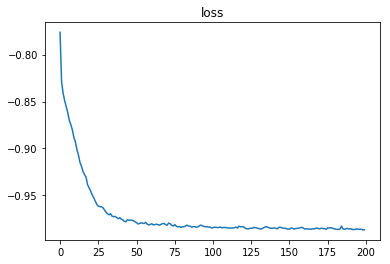

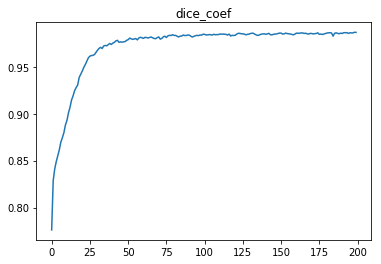

In [12]:
    #
    #   Show History
    #
    import matplotlib.pyplot as plt
    
    # load pickle
    print(dname_checkpoints + '/' + fname_history)
    history = pickle.load(open(dname_checkpoints + '/' + fname_history, 'rb'))

    for k in history.keys():
        plt.plot(history[k])
        plt.title(k)
        plt.show()